In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import shutil

In [233]:
all_images =  "E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\ALL-DEFECT-IMAGES"
target_dir = Path(r"E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\Structural-Defect-Images-Categories")
excel_path = "E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\XL-structural-defect\ServiceOrderItemDetails.xlsx"
sel_cat = ["Electrical","Carpet"]
temp_cat = ["Windows-sliding door"]

In [6]:
class ImageSeparator:
    def __init__(self,images_dir,target_dir,excel_path):
        self.excel_path = excel_path
        self.images_dir = images_dir
        self.df = pd.read_excel(self.excel_path,sheet_name="Sheet1") 
        self.target_dir = target_dir
      
    def getFolderNameFromXL(self,df):
        categories = self.df['Category']
        unique_categories = []
        for i in categories:
            if i not in unique_categories:
                unique_categories.append(i)
        return unique_categories
    
    
    def folder_creation(self,parent_dir):
        try:
            categories = self.getFolderNameFromXL(DF)
            
            for category in categories:
                folder = category.replace("/","-").replace(" ","_")
                path = os.path.join(parent_dir,folder)
                os.mkdir(path)
                print(f"folder {FOLDER} created")
            target_folders = os.listdir(parent_dir)
            return target_folders
        except:
            print("oops folder creation is unsuccessful")
            
    def append_files_based_on_category(self):
        #try:
        target_folders = os.listdir(self.target_dir)
        category = [category for category in self.df["Category"]]
        file_names = os.listdir(self.images_dir)

        for file in tqdm(file_names):
            head, tail = os.path.splitext(file)

            if tail in [".jpg", ".jpe", ".jpeg"]:
                v = head.split("_")
                snum = int(v[0])
                onum = int(float(v[1]))
                cat = self.df[(self.df["Service Order Number"]==snum) & (self.df["Item No. Order Doc."]==onum)]['Category'].values
            for folder_name in target_folders:
                    #old_name = folder_name.replace("-","/").replace("_"," ")
                    if (folder_name not in sel_cat and cat == folder_name) :
                        shutil.copy(f"{self.images_dir}\{file}",f"{self.target_dir}\{folder_name}\{file}")

        print("********* all files has been classified **********")   
#         except:
#             print("oops... flailed to save files")
            
                
# image_separator = ImageSeparator(all_images,target_dir,excel_path)
# image_separator.append_files_based_on_category()
    

In [7]:
# seperator = ImageSeparator(all_images,target_dir,excel_path)
# seperator.append_files_based_on_category()

In [248]:

class PrepareDataForModel:
    def __init__(self,augmented=True):
        self.size = (260,260)
        self.augmented = augmented
        
        
    def set_resolution(modelName,imgPath):
        path = "E:\STRUCTURAL-DEFECT-DETECTION\Super-Resolution -Models\ESPCN_x3.pb"
        img = cv2.imread(imgPath)
        sr_model = cv2.dnn_superres.DnnSuperResImpl_create()
        sr_model.readModel(path)
        model.setModel("espcn",3)
        sr_image = sr_model.upsample(img)
        img = sr_image[:,:,::-1]
        return img
        
    
    def data_augmentation(self,parent_dir_path,aug_X,category):
        data = np.array(aug_X)
        print(data[0][0].shape)
        #save_path = r"E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\op"
        save_path = f'{os.path.join(parent_dir_path,category)}'
        dataGenerator = ImageDataGenerator(samplewise_center=True,
                                           rotation_range=40,vertical_flip=True,horizontal_flip=True,
                                           brightness_range=(0.5,1.5),width_shift_range= (0.5,1.5),
                                           height_shift_range=(0.5,1.5),rescale=1./255.) 
        print(f"file saving to{save_path}")
        epoch = 15
        for batch in tqdm(dataGenerator.flow(data,batch_size=16,save_to_dir=save_path,
                                             save_prefix='aug',save_format='jpe')):
            epoch -=1
            if epoch <=1:
                break
    
        
    def set_image_size(self,file_name,parent_dir_path,category):
        path = os.path.join(os.path.join(parent_dir_path,category),file_name)
        head, tail = os.path.splitext(file_name)
        if tail in [".jpe"]:
            file = cv2.imread(path)
            file = cv2.resize(file,self.size)
            return file
              
        
    def data_augmentation_driver(self,parent_dir_path):
        X =[]
        y = []
        print('data_augmentation_driver initiated....')
        parent_dir = os.listdir(parent_dir_path)
        for category in tqdm(parent_dir):
#             if category in temp_cat:
#                 print(category)

            aug_X = []
            sub_dir = os.listdir(os.path.join(parent_dir_path,category))
            for file_name in sub_dir:
                path = os.path.join(os.path.join(parent_dir_path,category),file_name)
                head, tail = os.path.splitext(file_name)
                if tail in [".jpe"]:
                    print(file_name)
                    file = cv2.imread(path)
                    file = cv2.resize(file,self.size)
                #file = self.set_image_size(file_name,parent_dir_path,category)
                if not self.augmented:
                    aug_X.append(file)
                else:
                    X.extend([file])
                    y.extend([category])
            if len(aug_X):
                print("...data augmentation started...")
                self.data_augmentation(parent_dir_path,aug_X,category)

        if self.augmented:
            self.augmented = False
            print("data_augmentation_driver session ended....")
            print("features and labels are ready")
            X = np.array(X)
            y = np.array(y)
            return X,y
        self.augmented = True
        if self.augmented:
            return (self.data_augmentation_driver(parent_dir_path))
            
        print('************Anugmentation successfull **************')
    
    
            
        
    

In [249]:
prepare_data = PrepareDataForModel()

In [250]:
X,y = prepare_data.data_augmentation_driver("E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\Final-Merged-Categories")

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

data_augmentation_driver initiated....
8000073395_0000000010_1_MyProsperityDefectPhoto.jpe
8000073442_0000000010_1_MyProsperityDefectPhoto.jpe
8000073699_0000000010_1_MyProsperityDefectPhoto.jpe
8000073819_0000000010_1_MyProsperityDefectPhoto.jpe
8000073931_0000000050_1_MyProsperityDefectPhoto.jpe
8000073973_0000000010_1_MyProsperityDefectPhoto.jpe
8000074034_0000000050_1_IMG_4678.jpg.jpe
8000074034_0000000050_2_IMG_4679.jpg.jpe
8000074068_0000000010_1_MyProsperityDefectPhoto.jpe
8000074178_0000000010_1_Picture1.jpg.jpe
8000074185_0000000010_1_MyProsperityDefectPhoto.jpe
8000074202_0000000010_1_MyProsperityDefectPhoto.jpe
8000074297_0000000010_1_MyProsperityDefectPhoto.jpe
8000074361_0000000010_1_MyProsperityDefectPhoto.jpe
8000074382_0000000010_1_MyProsperityDefectPhoto.jpe
8000075369_0000000070_1_MyProsperityDefectPhoto.jpe
8000075622_0000000130_1_ImageFile.jpe
8000075655_0000000020_1_MyProsperityDefectPhoto.jpe
8000075655_0000000020_2_MyProsperityDefectPhoto.jpe
8000075655_000000003

  7%|█████▌                                                                             | 1/15 [00:06<01:25,  6.13s/it]

aug_36_6497.jpe
aug_36_8338.jpe
aug_37_3709.jpe
aug_37_5911.jpe
aug_38_6344.jpe
aug_38_8415.jpe
aug_39_6019.jpe
aug_3_3811.jpe
aug_40_7273.jpe
aug_40_8466.jpe
aug_41_7075.jpe
aug_42_1531.jpe
aug_42_4929.jpe
aug_43_6635.jpe
aug_43_9400.jpe
aug_44_4082.jpe
aug_45_2171.jpe
aug_45_7354.jpe
aug_46_247.jpe
aug_47_6891.jpe
aug_48_2260.jpe
aug_49_1174.jpe
aug_49_6529.jpe
aug_4_5944.jpe
aug_50_8413.jpe
aug_51_4653.jpe
aug_52_1993.jpe
aug_52_9073.jpe
aug_53_3334.jpe
aug_53_9459.jpe
aug_54_8269.jpe
aug_55_3831.jpe
aug_56_8907.jpe
aug_56_9038.jpe
aug_57_3175.jpe
aug_58_4190.jpe
aug_58_7930.jpe
aug_59_5391.jpe
aug_5_8167.jpe
aug_60_6033.jpe
aug_60_6775.jpe
aug_61_3170.jpe
aug_61_3464.jpe
aug_62_4378.jpe
aug_63_6511.jpe
aug_64_1208.jpe
aug_65_3915.jpe
aug_65_5604.jpe
aug_66_3762.jpe
aug_67_7461.jpe
aug_68_4980.jpe
aug_68_7217.jpe
aug_69_1350.jpe
aug_69_2256.jpe
aug_6_7211.jpe
aug_6_8747.jpe
aug_70_815.jpe
aug_71_2799.jpe
aug_71_9533.jpe
aug_72_7396.jpe
aug_73_6026.jpe
aug_74_962.jpe
aug_75_6449.jpe


8000076891_0000000010_1_MyProsperityDefectPhoto.jpe
8000076891_0000000010_2_MyProsperityDefectPhoto.jpe
8000076912_0000000010_1_IMG_7060.jpeg.jpe
8000076996_0000000010_1_IMG_3622.jpg.jpe
8000077031_0000000010_1_30Anchoragelightswitch.JPG.jpe
8000077062_0000000010_1_MyProsperityDefectPhoto.jpe
8000077070_0000000010_1_MyProsperityDefectPhoto.jpe
8000077097_0000000010_1_microwave.jpg.jpe
8000077111_0000000060_1_MyProsperityDefectPhoto.jpe
8000077116_0000000010_1_MyProsperityDefectPhoto.jpe
8000077116_0000000010_2_MyProsperityDefectPhoto.jpe
8000077129_0000000010_1_image1.jpg.jpe
8000077146_0000000010_1_IMG_0565.jpg.jpe
8000077150_0000000010_1_powerpoint.jpg.jpe
8000077158_0000000020_1_MyProsperityDefectPhoto.jpe
8000077166_0000000010_1_ImageFile.jpe
8000077166_0000000030_1_ImageFile.jpe
8000077166_0000000260_1_ImageFile.jpe
8000077188_0000000110_1_ImageFile.jpe
8000077226_0000000010_1_1DFC4EE1-407F-47CC-BCE5-CF55D7E65315.jpg.jpe
8000077291_0000000010_1_Kitchen-Stovetop_hotplates.jpg.jpe
8

8000081083_0000000010_2_IMG_9265.jpg.jpe
8000081083_0000000010_3_IMG_9266.jpg.jpe
8000081097_0000000010_1_Picture1.jpg.jpe
8000081146_0000000010_1_601MEbalconylight.jpg.jpe
8000081201_0000000030_1_ImageFile.jpe
8000081230_0000000020_1_MyProsperityDefectPhoto.jpe
8000081230_0000000020_2_MyProsperityDefectPhoto.jpe
8000081230_0000000030_1_MyProsperityDefectPhoto.jpe
8000081230_0000000030_2_MyProsperityDefectPhoto.jpe
8000081232_0000000010_1_MyProsperityDefectPhoto.jpe
8000081232_0000000010_2_MyProsperityDefectPhoto.jpe
8000081232_0000000010_3_MyProsperityDefectPhoto.jpe
8000081233_0000000010_1_MyProsperityDefectPhoto.jpe
8000081248_0000000010_1_IMG_1273.jpg.jpe
8000081248_0000000010_2_IMG_1274.jpg.jpe
8000081307_0000000010_1_IMG_1276.jpg.jpe
8000081307_0000000010_2_IMG_1277.jpg.jpe
8000081385_0000000010_2_MyProsperityDefectPhoto.jpe
8000081403_0000000010_1_MyProsperityDefectPhoto.jpe
8000081404_0000000010_1_MyProsperityDefectPhoto.jpe
8000081418_0000000010_1_lights.jpg.jpe
8000081421_000

8000086373_0000000020_2_20200819_024242862_iOS.jpg.jpe
8000086425_0000000010_1_MyProsperityDefectPhoto.jpe
8000086437_0000000050_1_IMG_3276.jpg.jpe
8000086437_0000000050_2_20200824_022512385_iOS.jpg.jpe
8000086454_0000000010_1_MyProsperityDefectPhoto.jpe
8000086471_0000000030_1_IMG_0911.jpg.jpe
8000086491_0000000010_1_ImageFile.jpe
8000086519_0000000010_1_MyProsperityDefectPhoto.jpe
8000086558_0000000030_1_MyProsperityDefectPhoto.jpe
8000086564_0000000030_1_MyProsperityDefectPhoto.jpe
8000086564_0000000030_2_20200831_030342683_iOS.jpg.jpe
8000086583_0000000010_1_ImageFile.jpe
8000086596_0000000010_1_IMG_1380.jpg.jpe
8000086655_0000000010_1_IMG_1353.jpg.jpe
8000086655_0000000010_2_IMG_1354.jpg.jpe
8000086655_0000000010_3_IMG_1357.jpg.jpe
8000086665_0000000010_1_1.jpg.jpe
8000086665_0000000010_2_2.jpg.jpe
8000086680_0000000010_1_1.jpg.jpe
8000086680_0000000010_2_2.jpg.jpe
8000086680_0000000010_3_3.jpg.jpe
8000086680_0000000010_4_4.jpg.jpe
8000086683_0000000010_3_1.jpg.jpe
8000086686_0000

 13%|███████████                                                                        | 2/15 [00:24<02:55, 13.51s/it]

aug_39_4090.jpe
aug_39_6643.jpe
aug_3_6188.jpe
aug_40_6409.jpe
aug_40_8738.jpe
aug_41_5149.jpe
aug_42_5203.jpe
aug_43_1608.jpe
aug_44_8561.jpe
aug_45_196.jpe
aug_46_8057.jpe
aug_46_8642.jpe
aug_47_1561.jpe
aug_47_3022.jpe
aug_47_3035.jpe
aug_48_2542.jpe
aug_48_8403.jpe
aug_49_201.jpe
aug_4_5765.jpe
aug_50_764.jpe
aug_50_8135.jpe
aug_51_948.jpe
aug_52_2562.jpe
aug_52_5316.jpe
aug_52_7406.jpe
aug_53_5244.jpe
aug_53_6796.jpe
aug_54_2513.jpe
aug_54_4908.jpe
aug_55_423.jpe
aug_56_4514.jpe
aug_56_6065.jpe
aug_57_7078.jpe
aug_58_7676.jpe
aug_59_7061.jpe
aug_59_9600.jpe
aug_5_7198.jpe
aug_5_988.jpe
aug_60_2658.jpe
aug_60_3710.jpe
aug_61_822.jpe
aug_61_9684.jpe
aug_62_3270.jpe
aug_62_8811.jpe
aug_63_7804.jpe
aug_63_8956.jpe
aug_64_3196.jpe
aug_65_7225.jpe
aug_66_1318.jpe
aug_66_5085.jpe
aug_67_1489.jpe
aug_67_182.jpe
aug_68_3177.jpe
aug_69_1003.jpe
aug_69_1988.jpe
aug_6_6085.jpe
aug_6_8631.jpe
aug_70_9668.jpe
aug_71_2439.jpe
aug_72_2143.jpe
aug_72_3157.jpe
aug_73_2252.jpe
aug_73_8580.jpe
aug_74

8000081799_0000000050_5_ImageFile.jpe
8000081921_0000000010_1_MyProsperityDefectPhoto.jpe
8000081921_0000000010_2_MyProsperityDefectPhoto.jpe
8000081935_0000000040_1_MyProsperityDefectPhoto.jpe
8000082600_0000000060_1_ImageFile.jpe
8000082605_0000000030_1_ImageFile.jpe
8000082605_0000000030_2_ImageFile.jpe
8000082605_0000000040_1_ImageFile.jpe
8000082612_0000000040_1_ImageFile.jpe
8000082612_0000000050_1_ImageFile.jpe
8000082898_0000000020_1_11152.0.jpg.jpe
8000083008_0000000040_1_MyProsperityDefectPhoto.jpe
8000083066_0000000080_1_ImageFile.jpe
8000083078_0000000010_1_ImageFile.jpe
8000083078_0000000060_1_ImageFile.jpe
8000083083_0000000010_1_ImageFile.jpe
8000083294_0000000180_1_ImageFile.jpe
8000083295_0000000020_1_ImageFile.jpe
8000083295_0000000060_1_ImageFile.jpe
8000083303_0000000020_1_ImageFile.jpe
8000083307_0000000010_1_ImageFile.jpe
8000083307_0000000010_2_ImageFile.jpe
8000083307_0000000030_1_ImageFile.jpe
8000083467_0000000040_1_ImageFile.jpe
8000083467_0000000040_2_ImageF

 20%|████████████████▌                                                                  | 3/15 [00:26<01:39,  8.30s/it]

aug_97_103.jpe
aug_98_3884.jpe
aug_99_8530.jpe
aug_9_104.jpe
8000073525_0000000110_1_ImageFile.jpe
8000073525_0000000140_1_ImageFile.jpe
8000073525_0000000140_2_ImageFile.jpe
8000073525_0000000150_1_ImageFile.jpe
8000073827_0000000090_1_ImageFile.jpe
8000073858_0000000020_1_ImageFile.jpe
8000073869_0000000020_1_ImageFile.jpe
8000074035_0000000010_1_MyProsperityDefectPhoto.jpe
8000074277_0000000010_3_ImageFile.jpe
8000074426_0000000030_1_ImageFile.jpe
8000074534_0000000070_1_ImageFile.jpe
8000074572_0000000020_1_ImageFile.jpe
8000074572_0000000020_2_ImageFile.jpe
8000074572_0000000020_3_ImageFile.jpe
8000074652_0000000010_1_ImageFile.jpe
8000074658_0000000020_1-ImageFile.jpe
8000074659_0000000020_1_ImageFile.jpe
8000074660_0000000020_1_ImageFile.jpe
8000074811_0000000030_1_ImageFile.jpe
8000074913_0000000390_1_ImageFile.jpe
8000074919_0000000210_1_ImageFile.jpe
8000074945_0000000080_1_ImageFile.jpe
8000074945_0000000080_2_ImageFile.jpe
8000074969_0000000070_1_ImageFile.jpe
8000075096_00

8000085769_0000000120_1_ImageFile.jpe
8000085769_0000000120_2_ImageFile.jpe
8000085773_0000000030_1_ImageFile.jpe
8000085779_0000000020_1_ImageFile.jpe
8000085787_0000000030_2_ImageFile.jpe
8000085787_0000000040_1_ImageFile.jpe
8000085802_0000000020_1_ImageFile.jpe
8000085818_0000000030_1_ImageFile.jpe
8000085832_0000000010_1_ImageFile.jpe
8000085837_0000000030_1_ImageFile.jpe
8000085919_0000000030_1_ImageFile.jpe
8000085969_0000000050_1_ImageFile.jpe
8000085971_0000000020_1_ImageFile.jpe
8000085980_0000000030_1_ImageFile.jpe
8000085986_0000000200_1_ImageFile.jpe
8000085986_0000000210_1_ImageFile.jpe
8000085986_0000000280_1_ImageFile.jpe
8000085986_0000000280_2_ImageFile.jpe
8000085986_0000000280_3_ImageFile.jpe
8000086171_0000000040_1_ImageFile.jpe
8000086189_0000000020_2_ImageFile.jpe
8000086200_0000000020_1_ImageFile.jpe
8000086201_0000000020_1_ImageFile.jpe
8000086291_0000000050_1_ImageFile.jpe
8000086294_0000000060_2_ImageFile.jpe
8000086294_0000000060_3_ImageFile.jpe
8000086341_0

 27%|██████████████████████▏                                                            | 4/15 [00:34<01:26,  7.85s/it]

aug_245_2578.jpe
aug_246_9176.jpe
aug_248_7780.jpe
aug_249_7711.jpe
aug_250_2395.jpe
aug_251_8259.jpe
aug_252_6474.jpe
aug_254_4392.jpe
aug_256_1039.jpe
aug_257_2311.jpe
aug_259_2157.jpe
aug_260_9322.jpe
aug_262_6567.jpe
aug_263_5896.jpe
aug_264_9329.jpe
aug_267_8834.jpe
aug_268_8324.jpe
aug_269_1340.jpe
aug_270_1505.jpe
aug_273_5281.jpe
aug_275_9266.jpe
aug_276_8720.jpe
aug_277_1730.jpe
aug_278_8837.jpe
aug_280_260.jpe
aug_281_9432.jpe
aug_283_4996.jpe
aug_284_2260.jpe
aug_285_9458.jpe
aug_288_688.jpe
aug_289_2617.jpe
aug_28_6275.jpe
aug_290_9268.jpe
aug_291_1029.jpe
aug_292_4735.jpe
aug_294_2889.jpe
aug_295_5271.jpe
aug_296_981.jpe
aug_297_9126.jpe
aug_299_9982.jpe
aug_29_3498.jpe
aug_301_3949.jpe
aug_302_8882.jpe
aug_303_9531.jpe
aug_304_95.jpe
aug_305_1911.jpe
aug_306_2676.jpe
aug_307_3318.jpe
aug_309_2207.jpe
aug_30_6113.jpe
aug_310_8155.jpe
aug_311_9302.jpe
aug_315_9117.jpe
aug_316_7242.jpe
aug_318_3925.jpe
aug_319_5078.jpe
aug_31_4941.jpe
aug_320_4430.jpe
aug_33_9498.jpe
aug_34_

8000075261_0000000090_1_ImageFile.jpe
8000075261_0000000110_1_ImageFile.jpe
8000075261_0000000110_2_ImageFile.jpe
8000075261_0000000120_1_ImageFile.jpe
8000075261_0000000230_1_ImageFile.jpe
8000075261_0000000230_2_ImageFile.jpe
8000075261_0000000300_1_ImageFile.jpe
8000075267_0000000010_1_ImageFile.jpe
8000075267_0000000050_1_ImageFile.jpe
8000075267_0000000060_1_ImageFile.jpe
8000075267_0000000140_1_ImageFile.jpe
8000075267_0000000140_2_ImageFile.jpe
8000075267_0000000150_1_ImageFile.jpe
8000075267_0000000160_1_ImageFile.jpe
8000075267_0000000170_1_ImageFile.jpe
8000075267_0000000210_1_ImageFile.jpe
8000075267_0000000210_2_ImageFile.jpe
8000075267_0000000210_3_ImageFile.jpe
8000075267_0000000220_1_ImageFile.jpe
8000075267_0000000230_1_ImageFile.jpe
8000075267_0000000230_2_ImageFile.jpe
8000075267_0000000250_1_ImageFile.jpe
8000075267_0000000250_2_ImageFile.jpe
8000075269_0000000040_1_ImageFile.jpe
8000075269_0000000080_1_ImageFile.jpe
8000075269_0000000080_2_ImageFile.jpe
8000075269_0

8000081191_0000000050_1_ImageFile.jpe
8000081191_0000000060_1_ImageFile.jpe
8000081191_0000000090_1_ImageFile.jpe
8000081191_0000000130_1_ImageFile.jpe
8000081191_0000000140_1_ImageFile.jpe
8000081191_0000000200_1_ImageFile.jpe
8000081192_0000000050_1_ImageFile.jpe
8000081192_0000000060_1_ImageFile.jpe
8000081192_0000000060_2_ImageFile.jpe
8000081192_0000000160_1_ImageFile.jpe
8000081197_0000000080_1_ImageFile.jpe
8000081197_0000000270_1_ImageFile.jpe
8000081203_0000000040_1_ImageFile.jpe
8000081203_0000000050_1_ImageFile.jpe
8000081203_0000000050_2_ImageFile.jpe
8000081203_0000000070_1_ImageFile.jpe
8000081203_0000000080_1_ImageFile.jpe
8000081203_0000000090_1_ImageFile.jpe
8000081203_0000000100_1_ImageFile.jpe
8000081203_0000000120_1_ImageFile.jpe
8000081203_0000000130_1_ImageFile.jpe
8000081203_0000000150_1_ImageFile.jpe
8000081208_0000000020_1_IMG_5427.jpg.jpe
8000081208_0000000020_2_IMG_5428.jpg.jpe
8000081214_0000000010_1_MyProsperityDefectPhoto.jpe
8000081214_0000000010_2_MyPros

8000086326_0000000040_1_ImageFile.jpe
8000086326_0000000050_1_ImageFile.jpe
8000086326_0000000060_1_ImageFile.jpe
8000086326_0000000070_1_ImageFile.jpe
8000086326_0000000090_1_ImageFile.jpe
8000086326_0000000100_1_ImageFile.jpe
8000086326_0000000110_1_ImageFile.jpe
8000086326_0000000120_1_ImageFile.jpe
8000086326_0000000130_1_ImageFile.jpe
8000086326_0000000140_1_ImageFile.jpe
8000086327_0000000010_1_ImageFile.jpe
8000086327_0000000050_1_ImageFile.jpe
8000086328_0000000010_1_ImageFile.jpe
8000086328_0000000020_1_ImageFile.jpe
8000086328_0000000040_1_ImageFile.jpe
8000086328_0000000060_1_ImageFile.jpe
8000086328_0000000070_1_ImageFile.jpe
8000086329_0000000010_1_ImageFile.jpe
8000086329_0000000020_1_ImageFile.jpe
8000086329_0000000030_1_ImageFile.jpe
8000086329_0000000070_1_ImageFile.jpe
8000086329_0000000080_1_ImageFile.jpe
8000086414_0000000010_1_MyProsperityDefectPhoto.jpe
8000086414_0000000010_2_20200817_033344099_iOS.jpg.jpe
8000086414_0000000020_1_MyProsperityDefectPhoto.jpe
80000

 33%|███████████████████████████▋                                                       | 5/15 [00:43<01:24,  8.47s/it]

aug_46_8321.jpe
aug_472_3980.jpe
aug_475_9726.jpe
aug_479_1537.jpe
aug_480_9624.jpe
aug_481_4219.jpe
aug_482_8934.jpe
aug_483_6982.jpe
aug_488_2132.jpe
aug_496_2105.jpe
aug_498_3162.jpe
aug_49_448.jpe
aug_500_261.jpe
aug_501_6300.jpe
aug_50_5893.jpe
aug_512_1860.jpe
aug_513_6909.jpe
aug_515_9985.jpe
aug_518_1078.jpe
aug_520_9768.jpe
aug_521_2975.jpe
aug_526_9688.jpe
aug_529_1466.jpe
aug_531_4194.jpe
aug_533_3309.jpe
aug_534_2060.jpe
aug_536_8693.jpe
aug_537_4260.jpe
aug_538_7769.jpe
aug_543_1506.jpe
aug_546_4015.jpe
aug_549_2174.jpe
aug_54_4398.jpe
aug_554_343.jpe
aug_555_6544.jpe
aug_556_1300.jpe
aug_557_4003.jpe
aug_558_8266.jpe
aug_55_9653.jpe
aug_562_7210.jpe
aug_565_6551.jpe
aug_567_4367.jpe
aug_568_299.jpe
aug_572_4597.jpe
aug_576_1518.jpe
aug_579_6056.jpe
aug_581_407.jpe
aug_588_2594.jpe
aug_589_2589.jpe
aug_591_3699.jpe
aug_595_5289.jpe
aug_59_444.jpe
aug_606_4811.jpe
aug_609_22.jpe
aug_60_8517.jpe
aug_610_4806.jpe
aug_614_8037.jpe
aug_615_1493.jpe
aug_617_8346.jpe
aug_626_5765

8000079949_0000000020_2_MyProsperityDefectPhoto.jpe
8000080025_0000000010_1_MyProsperityDefectPhoto.jpe
8000080025_0000000010_2_ImageFile.jpe
8000080077_0000000010_1_ImageFile.jpe
8000080077_0000000030_1_ImageFile.jpe
8000080077_0000000130_1_ImageFile.jpe
8000080152_0000000050_1_ImageFile.jpe
8000080156_0000000010_1_ImageFile.jpe
8000080165_0000000020_1_ImageFile.jpe
8000080165_0000000020_2_ImageFile.jpe
8000080245_0000000040_1_ImageFile.jpe
8000080378_0000000040_1_ImageFile.jpe
8000080424_0000000020_1_ImageFile.jpe
8000080434_0000000020_1_IMG_9184.JPG.jpe
8000080453_0000000020_1_MyProsperityDefectPhoto.jpe
8000080453_0000000020_2_ImageFile.jpe
8000080473_0000000010_1_MyProsperityDefectPhoto.jpe
8000080473_0000000010_2_MyProsperityDefectPhoto.jpe
8000080473_0000000020_1_MyProsperityDefectPhoto.jpe
8000080473_0000000030_1_MyProsperityDefectPhoto.jpe
8000080503_0000000020_1_MyProsperityDefectPhoto.jpe
8000080629_0000000060_1_ImageFile.jpe
8000080629_0000000060_2_ImageFile.jpe
8000080629_

aug_193_9146.jpe
aug_194_7646.jpe
aug_195_3495.jpe
aug_195_4212.jpe
aug_196_275.jpe
aug_196_8316.jpe
aug_197_1051.jpe
aug_197_4934.jpe
aug_198_8139.jpe
aug_19_8884.jpe
aug_1_1150.jpe
aug_200_9087.jpe
aug_201_7356.jpe
aug_202_5049.jpe
aug_203_2671.jpe
aug_203_5033.jpe
aug_204_3663.jpe
aug_204_8162.jpe
aug_205_1854.jpe
aug_206_6289.jpe
aug_207_2541.jpe
aug_209_1106.jpe
aug_20_3046.jpe
aug_210_7073.jpe
aug_211_6808.jpe
aug_213_9565.jpe
aug_214_8363.jpe
aug_214_9768.jpe
aug_215_3317.jpe
aug_215_9068.jpe
aug_216_468.jpe
aug_217_5118.jpe
aug_218_8056.jpe
aug_219_2016.jpe
aug_219_8127.jpe
aug_21_1156.jpe
aug_220_5638.jpe
aug_221_6808.jpe
aug_221_8336.jpe
aug_222_7266.jpe
aug_223_5496.jpe
aug_224_5736.jpe
aug_225_7297.jpe
aug_226_1289.jpe
aug_227_662.jpe
aug_227_8751.jpe
aug_228_1687.jpe
aug_228_9782.jpe
aug_229_5013.jpe
aug_229_6607.jpe
aug_230_7410.jpe
aug_231_140.jpe
aug_231_4782.jpe
aug_232_1241.jpe
aug_233_9930.jpe
aug_234_4890.jpe
aug_234_52.jpe
aug_235_198.jpe
aug_236_6978.jpe
aug_236_8

 40%|█████████████████████████████████▏                                                 | 6/15 [00:49<01:06,  7.44s/it]

aug_502_93.jpe
aug_504_5823.jpe
aug_508_3387.jpe
aug_509_212.jpe
aug_50_1705.jpe
aug_50_6688.jpe
aug_512_6663.jpe
aug_513_1343.jpe
aug_514_8168.jpe
aug_516_943.jpe
aug_517_3237.jpe
aug_518_5183.jpe
aug_520_214.jpe
aug_522_6854.jpe
aug_52_6756.jpe
aug_53_2321.jpe
aug_53_7050.jpe
aug_55_5718.jpe
aug_56_7519.jpe
aug_57_2552.jpe
aug_58_5433.jpe
aug_59_1533.jpe
aug_5_2146.jpe
aug_5_3615.jpe
aug_60_4797.jpe
aug_61_8452.jpe
aug_62_4827.jpe
aug_63_4743.jpe
aug_64_209.jpe
aug_64_6314.jpe
aug_65_6620.jpe
aug_66_6405.jpe
aug_67_7973.jpe
aug_68_5774.jpe
aug_69_8836.jpe
aug_6_5823.jpe
aug_6_6794.jpe
aug_70_8811.jpe
aug_70_9635.jpe
aug_72_7681.jpe
aug_73_225.jpe
aug_73_5861.jpe
aug_74_3361.jpe
aug_75_5352.jpe
aug_76_1011.jpe
aug_76_5578.jpe
aug_77_8259.jpe
aug_79_7181.jpe
aug_7_2826.jpe
aug_80_2020.jpe
aug_80_2400.jpe
aug_81_7268.jpe
aug_82_5489.jpe
aug_82_8650.jpe
aug_83_2908.jpe
aug_84_6522.jpe
aug_85_1209.jpe
aug_86_3005.jpe
aug_87_8519.jpe
aug_88_1459.jpe
aug_89_1763.jpe
aug_89_7943.jpe
aug_91_1

8000078358_0000000010_1_MyProsperityDefectPhoto.jpe
8000078482_0000000030_1_Picture2.jpg.jpe
8000078494_0000000120_1_ImageFile.jpe
8000078494_0000000160_1_ImageFile.jpe
8000078517_0000000010_5_20190705_011900263_iOS.jpg.jpe
8000078552_0000000020_1_Picture2.jpg.jpe
8000078744_0000000010_1_image.jpg.jpe
8000078765_0000000010_1_20190705_011349895_iOS.jpg.jpe
8000078765_0000000010_2_20200508_004022391_iOS.jpg.jpe
8000078765_0000000010_5_20200508_004732183_iOS.jpg.jpe
8000078765_0000000010_7_20200508_004906509_iOS.jpg.jpe
8000078887_0000000010_1_1.jpg.jpe
8000079211_0000000020_1_ImageFile.jpe
8000079260_0000000060_1_ImageFile.jpe
8000079260_0000000070_1_ImageFile.jpe
8000079272_0000000040_1_ImageFile.jpe
8000079272_0000000040_2_ImageFile.jpe
8000079304_0000000010_1_ImageFile.jpe
8000079304_0000000040_1_ImageFile.jpe
8000079304_0000000460_1_ImageFile.jpe
8000079386_0000000010_1_ImageFile.jpe
8000079386_0000000030_1_ImageFile.jpe
8000079414_0000000030_1_ImageFile.jpe
8000079417_0000000020_1_I

8000084637_0000000010_2_20200429_163043.jpg.jpe
8000084742_0000000010_1_ImageFile.jpe
8000084742_0000000010_2_ImageFile.jpe
8000084790_0000000040_1_FullSizeRender.jpeg.jpe
8000085239_0000000100_1_ImageFile.jpe
8000085239_0000000100_2_ImageFile.jpe
8000085239_0000000200_1_ImageFile.jpe
8000085280_0000000010_2_20200610_004517280_iOS.jpg.jpe
8000085317_0000000020_1_MyProsperityDefectPhoto.jpe
8000085323_0000000020_1_2..jpg.jpe
8000085323_0000000020_2_2.jpg.jpe
8000085355_0000000020_1_bedroom1-doorhandle.jpg.jpe
8000085355_0000000040_1_bathroomdoor.jpg.jpe
8000085355_0000000060_1_ImageFile.jpe
8000085402_0000000020_1_ImageFile.jpe
8000085749_0000000200_1_ImageFile.jpe
8000085840_0000000010_1_20200716_020229000_iOS.jpg.jpe
8000085840_0000000010_2_20200716_020330313_iOS.jpg.jpe
8000085840_0000000010_3_20200716_020204696_iOS.jpg.jpe
8000085930_0000000010_1_ImageFile.jpe
8000085950_0000000030_1_ImageFile.jpe
8000085950_0000000030_2_ImageFile.jpe
8000085956_0000000020_1_ImageFile.jpe
8000085980

 47%|██████████████████████████████████████▋                                            | 7/15 [01:00<01:09,  8.72s/it]

8000088413_0000000010_2_ImageFile.jpe
8000088413_0000000010_3_ImageFile.jpe
8000088413_0000000010_4_ImageFile.jpe
aug_101_3278.jpe
aug_104_1606.jpe
aug_106_5119.jpe
aug_107_5946.jpe
aug_108_507.jpe
aug_109_6548.jpe
aug_111_6002.jpe
aug_117_6597.jpe
aug_119_5344.jpe
aug_11_7549.jpe
aug_120_1816.jpe
aug_121_420.jpe
aug_123_1271.jpe
aug_124_6926.jpe
aug_125_2318.jpe
aug_126_4689.jpe
aug_129_911.jpe
aug_12_5543.jpe
aug_130_7182.jpe
aug_133_8023.jpe
aug_134_5598.jpe
aug_140_3757.jpe
aug_141_6857.jpe
aug_147_9150.jpe
aug_149_4213.jpe
aug_14_7658.jpe
aug_152_4874.jpe
aug_153_7026.jpe
aug_156_3958.jpe
aug_157_4594.jpe
aug_15_252.jpe
aug_16_2186.jpe
aug_19_1073.jpe
aug_20_6881.jpe
aug_23_1406.jpe
aug_25_3450.jpe
aug_26_8810.jpe
aug_28_1854.jpe
aug_2_3952.jpe
aug_30_9798.jpe
aug_36_7502.jpe
aug_3_6991.jpe
aug_40_7113.jpe
aug_41_7047.jpe
aug_42_5208.jpe
aug_43_3118.jpe
aug_44_2374.jpe
aug_45_1411.jpe
aug_46_7777.jpe
aug_47_4501.jpe
aug_48_2971.jpe
aug_4_904.jpe
aug_51_9415.jpe
aug_55_2793.jpe
aug

 53%|████████████████████████████████████████████▎                                      | 8/15 [01:02<00:46,  6.64s/it]

aug_72_1651.jpe
aug_72_3543.jpe
aug_72_5891.jpe
aug_73_102.jpe
aug_73_6780.jpe
aug_74_2107.jpe
aug_74_775.jpe
aug_74_9474.jpe
aug_75_5456.jpe
aug_75_5597.jpe
aug_75_5650.jpe
aug_76_4193.jpe
aug_76_4619.jpe
aug_76_9676.jpe
aug_77_5802.jpe
aug_77_6429.jpe
aug_77_8184.jpe
aug_78_4316.jpe
aug_78_8474.jpe
aug_7_5824.jpe
aug_7_9453.jpe
aug_8_4751.jpe
aug_8_5545.jpe
aug_8_8469.jpe
aug_9_1887.jpe
aug_9_2273.jpe
aug_9_2812.jpe
8000073623_0000000030_1_IMG_3539.JPG.jpe
8000073732_0000000020_1_MyProsperityDefectPhoto.jpe
8000073810_0000000020_3_ImageFile.jpe
8000073810_0000000020_4_ImageFile.jpe
8000074309_0000000150_1_ImageFile.jpe
8000074309_0000000150_2_ImageFile.jpe
8000074309_0000000170_1_ImageFile.jpe
8000074309_0000000170_2_ImageFile.jpe
8000074309_0000000170_3_ImageFile.jpe
8000074309_0000000260_2_ImageFile.jpe
8000074332_0000000020_1_ImageFile.jpe
8000074546_0000000020_1_ImageFile.jpe
8000074572_0000000050_1_ImageFile.jpe
8000074572_0000000050_2_ImageFile.jpe
8000074793_0000000010_1_MyPro

 60%|█████████████████████████████████████████████████▊                                 | 9/15 [01:06<00:33,  5.66s/it]

aug_99_9178.jpe
aug_99_9386.jpe
aug_9_3927.jpe
aug_9_6597.jpe
8000073292_0000000030_1_MyProsperityDefectPhoto.jpe
8000073623_0000000020_3_ImageFile.jpe
8000073732_0000000010_2_MyProsperityDefectPhoto.jpe
8000073827_0000000060_3_ImageFile.jpe
8000073827_0000000080_1_ImageFile.jpe
8000073827_0000000100_1_ImageFile.jpe
8000073827_0000000100_2_ImageFile.jpe
8000073827_0000000100_3_ImageFile.jpe
8000073931_0000000030_1_MyProsperityDefectPhoto.jpe
8000073950_0000000080_1_MyProsperityDefectPhoto.jpe
8000073950_0000000080_2_MyProsperityDefectPhoto.jpe
8000073952_0000000020_1_MyProsperityDefectPhoto.jpe
8000073952_0000000020_2_MyProsperityDefectPhoto.jpe
8000073953_0000000010_1_MyProsperityDefectPhoto.jpe
8000073953_0000000010_2_MyProsperityDefectPhoto.jpe
8000074082_0000000010_1_MyProsperityDefectPhoto.jpe
8000074082_0000000010_2_MyProsperityDefectPhoto.jpe
8000074082_0000000020_1_MyProsperityDefectPhoto.jpe
8000074082_0000000020_2_MyProsperityDefectPhoto.jpe
8000074113_0000000010_1_MyProsperi

8000076529_0000000020_1_MyProsperityDefectPhoto.jpe
8000076529_0000000030_1_MyProsperityDefectPhoto.jpe
8000076633_0000000010_1_MyProsperityDefectPhoto.jpe
8000076645_0000000010_1_ImageFile.jpe
8000076645_0000000010_3_ImageFile.jpe
8000076711_0000000060_1_MyProsperityDefectPhoto.jpe
8000076713_0000000010_1_900810.jpg.jpe
8000076713_0000000030_1_9008301.jpg.jpe
8000076713_0000000030_2_900830.jpg.jpe
8000076883_0000000010_1_MyProsperityDefectPhoto.jpe
8000076883_0000000010_2_ImageFile.jpe
8000077111_0000000020_1_MyProsperityDefectPhoto.jpe
8000077111_0000000020_2_MyProsperityDefectPhoto.jpe
8000077111_0000000120_1_MyProsperityDefectPhoto.jpe
8000077183_0000000020_1_Picture2.jpg.jpe
8000077188_0000000010_1_MyProsperityDefectPhoto.jpe
8000077188_0000000090_1_MyProsperityDefectPhoto.jpe
8000077188_0000000090_2_MyProsperityDefectPhoto.jpe
8000077219_0000000010_1_IMG_7701.jpg.jpe
8000077219_0000000010_3_IMG_7705.jpg.jpe
8000077819_0000000010_1_Picture1.jpg.jpe
8000077819_0000000010_2_Picture2

8000083745_0000000210_1_MyProsperityDefectPhoto.jpe
8000083752_0000000010_1_70Anchorage1.JPG.jpe
8000083752_0000000010_2_70Anchorage2.jpg.jpe
8000083829_0000000040_1_ImageFile.jpe
8000083865_0000000010_1_MyProsperityDefectPhoto.jpe
8000083865_0000000010_2_MyProsperityDefectPhoto.jpe
8000083865_0000000020_1_MyProsperityDefectPhoto.jpe
8000083865_0000000020_2_MyProsperityDefectPhoto.jpe
8000083898_0000000020_1_MyProsperityDefectPhoto.jpe
8000083941_0000000010_1_MyProsperityDefectPhoto.jpe
8000083944_0000000010_1_image1.jpg.jpe
8000083944_0000000010_2_image2.jpg.jpe
8000084292_0000000010_1_20200408_043847.jpg.jpe
8000084292_0000000010_2_20200408_043849.jpg.jpe
8000084420_0000000010_1_MyProsperityDefectPhoto.jpe
8000084420_0000000010_2_MyProsperityDefectPhoto.jpe
8000084669_0000000010_1_ImageFile.jpe
8000084792_0000000010_1_Picture1.jpg.jpe
8000084792_0000000010_2_Picture2.jpg.jpe
8000084792_0000000010_3_Picture3.jpg.jpe
8000084850_0000000010_3_ImageFile.jpe
8000084850_0000000010_5_ImageFi

8000087795_0000000050_4_20201202_222845141_iOS.jpg.jpe
8000087795_0000000050_5_20201202_222859049_iOS.jpg.jpe
8000087851_0000000040_2_4.jpg.jpe
8000087865_0000000040_2_ImageFile.jpe
8000087866_0000000010_1_1.jpg.jpe
8000087913_0000000050_1_MyProsperityDefectPhoto.jpe
8000087913_0000000050_2_MyProsperityDefectPhoto.jpe
8000087913_0000000050_4_ImageFile.jpe
8000087913_0000000050_5_ImageFile.jpe
8000087913_0000000050_6_20201126_234251015_iOS.jpg.jpe
8000087913_0000000050_7_20201126_234209033_iOS.jpg.jpe
8000087913_0000000050_8_20201126_234026204_iOS.jpg.jpe
8000087929_0000000010_1_IMG20201116111049.jpg.jpe
8000087932_0000000020_1_MyProsperityDefectPhoto.jpe
8000087932_0000000020_2_MyProsperityDefectPhoto.jpe
8000087953_0000000010_1_G01balcony1.jpg.jpe
8000087953_0000000010_2_G01balcony2.jpg.jpe
8000087953_0000000010_3_G01balcony3.jpg.jpe
8000087973_0000000020_1_9010kitchentile.jpg.jpe
8000087973_0000000020_2_ImageFile.jpe
8000087973_0000000020_3_ImageFile.jpe
8000087973_0000000040_1_9010u

 67%|██████████████████████████████████████████████████████▋                           | 10/15 [01:24<00:48,  9.65s/it]

aug_67_1158.jpe
aug_67_6929.jpe
aug_67_8566.jpe
aug_68_6839.jpe
aug_68_8815.jpe
aug_68_9770.jpe
aug_69_1496.jpe
aug_69_2875.jpe
aug_69_7511.jpe
aug_69_7942.jpe
aug_6_2465.jpe
aug_6_4716.jpe
aug_6_6910.jpe
aug_6_8393.jpe
aug_70_228.jpe
aug_70_7335.jpe
aug_70_8706.jpe
aug_71_2233.jpe
aug_71_5485.jpe
aug_71_5929.jpe
aug_71_9100.jpe
aug_73_1328.jpe
aug_74_3406.jpe
aug_76_2244.jpe
aug_79_9847.jpe
aug_7_3590.jpe
aug_7_3720.jpe
aug_7_9992.jpe
aug_86_4335.jpe
aug_87_6094.jpe
aug_8_1299.jpe
aug_8_5043.jpe
aug_8_740.jpe
aug_91_5872.jpe
aug_93_4105.jpe
aug_94_5893.jpe
aug_95_239.jpe
aug_96_4492.jpe
aug_97_2914.jpe
aug_99_2918.jpe
aug_9_182.jpe
aug_9_2620.jpe
aug_9_4491.jpe
aug_9_7162.jpe
8000073290_0000000020_1_MyProsperityDefectPhoto.jpe
8000073451_0000000020_1_MyProsperityDefectPhoto.jpe
8000073451_0000000020_2_MyProsperityDefectPhoto.jpe
8000073525_0000000330_1_ImageFile.jpe
8000073525_0000000330_2_ImageFile.jpe
8000073525_0000000330_3_ImageFile.jpe
8000073564_0000000010_1_MyProsperityDefectPh

8000080152_0000000020_1_ImageFile.jpe
8000080399_0000000010_1_ImageFile.jpe
8000080399_0000000010_2_ImageFile.jpe
8000080538_0000000010_1_IMG_2257.jpeg.jpe
8000080538_0000000010_2_IMG_2258.JPG.jpe
8000080538_0000000020_1_IMG_2256.JPG.jpe
8000080538_0000000030_1_IMG_2256.JPG.jpe
8000080538_0000000030_2_ImageFile.jpe
8000080603_0000000010_1_MyProsperityDefectPhoto.jpe
8000080603_0000000010_2_MyProsperityDefectPhoto.jpe
8000080746_0000000290_1_ImageFile.jpe
8000080746_0000000290_2_ImageFile.jpe
8000080881_0000000010_1_MyProsperityDefectPhoto.jpe
8000080881_0000000010_2_MyProsperityDefectPhoto.jpe
8000081011_0000000020_1_MyProsperityDefectPhoto.jpe
8000081203_0000000190_1_ImageFile.jpe
8000081203_0000000200_1_ImageFile.jpe
8000081203_0000000200_2_ImageFile.jpe
8000081352_0000000010_1_MyProsperityDefectPhoto.jpe
8000081352_0000000020_1_MyProsperityDefectPhoto.jpe
8000081632_0000000060_1_ImageFile.jpe
8000081677_0000000110_1_ImageFile.jpe
8000081876_0000000010_1_image.jpg.jpe
8000081934_0000

8000086543_0000000020_1_Plastertoensuite.jpg.jpe
8000086560_0000000010_1_1.jpg.jpe
8000086560_0000000010_5_5.jpg.jpe
8000086560_0000000010_7_7.jpg.jpe
8000086560_0000000010_8_8.jpg.jpe
8000086565_0000000010_1_MyProsperityDefectPhoto.jpe
8000086565_0000000010_2_MyProsperityDefectPhoto.jpe
8000086583_0000000030_1_ImageFile.jpe
8000086620_0000000090_1_MyProsperityDefectPhoto.jpe
8000086620_0000000100_1_MyProsperityDefectPhoto.jpe
8000086653_0000000030_1_MyProsperityDefectPhoto.jpe
8000086653_0000000040_1_MyProsperityDefectPhoto.jpe
8000086653_0000000040_2_MyProsperityDefectPhoto.jpe
8000086653_0000000050_1_MyProsperityDefectPhoto.jpe
8000086760_0000000010_1_12Ironwood1.jpg.jpe
8000086802_0000000010_1_MyProsperityDefectPhoto.jpe
8000086802_0000000010_2_MyProsperityDefectPhoto.jpe
8000086802_0000000030_1_MyProsperityDefectPhoto.jpe
8000086802_0000000030_2_MyProsperityDefectPhoto.jpe
8000086816_0000000010_1_20200902_130940.jpg.jpe
8000086885_0000000010_1_20200829_160129.jpg.jpe
8000086885_00

 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:36<00:40, 10.19s/it]

aug_452_5450.jpe
aug_453_7906.jpe
aug_456_3033.jpe
aug_45_9616.jpe
aug_462_2150.jpe
aug_465_9162.jpe
aug_466_2836.jpe
aug_468_8428.jpe
aug_470_9925.jpe
aug_475_9985.jpe
aug_477_3078.jpe
aug_47_3251.jpe
aug_480_5721.jpe
aug_485_2819.jpe
aug_488_1631.jpe
aug_489_163.jpe
aug_490_5623.jpe
aug_494_2501.jpe
aug_496_9776.jpe
aug_501_3753.jpe
aug_503_6288.jpe
aug_504_6413.jpe
aug_505_475.jpe
aug_506_2218.jpe
aug_53_2737.jpe
aug_54_6476.jpe
aug_55_4678.jpe
aug_56_4338.jpe
aug_57_6398.jpe
aug_58_8702.jpe
aug_5_5570.jpe
aug_61_4560.jpe
aug_65_4226.jpe
aug_69_1322.jpe
aug_70_1656.jpe
aug_75_3663.jpe
aug_77_9957.jpe
aug_7_1074.jpe
aug_82_2052.jpe
aug_86_9230.jpe
aug_87_4792.jpe
aug_88_7628.jpe
aug_91_8466.jpe
aug_93_6735.jpe
aug_94_7005.jpe
aug_96_9713.jpe
aug_98_8480.jpe
8000073456_0000000010_1_MyProsperityDefectPhoto.jpe
8000073521_0000000020_4_DSC02638.JPG.jpe
8000073581_0000000010_1_MyProsperityDefectPhoto.jpe
8000073642_0000000020_1_MyProsperityDefectPhoto.jpe
8000073642_0000000020_2_MyProsper

8000082254_0000000010_2_tank2.jpg.jpe
8000082466_0000000010_1_MyProsperityDefectPhoto.jpe
8000082514_0000000010_1_MyProsperityDefectPhoto.jpe
8000082669_0000000010_1_ImageFile.jpe
8000082669_0000000050_1_ImageFile.jpe
8000082885_0000000010_1_89011.jpg.jpe
8000082897_0000000030_1_MyProsperityDefectPhoto.jpe
8000082897_0000000030_2_MyProsperityDefectPhoto.jpe
8000082897_0000000050_1_MyProsperityDefectPhoto.jpe
8000082897_0000000050_2_MyProsperityDefectPhoto.jpe
8000083066_0000000040_1_ImageFile.jpe
8000083066_0000000050_1_ImageFile.jpe
8000083066_0000000250_1_ImageFile.jpe
8000083077_0000000050_1_ImageFile.jpe
8000083080_0000000120_1_ImageFile.jpe
8000083292_0000000010_1_watertankleak.jpeg.jpe
8000083294_0000000250_1_ImageFile.jpe
8000083294_0000000270_1_ImageFile.jpe
8000083294_0000000290_1_ImageFile.jpe
8000083467_0000000010_1_ImageFile.jpe
8000083467_0000000020_1_ImageFile.jpe
8000083557_0000000010_1_ImageFile.jpe
8000083557_0000000010_2_ImageFile.jpe
8000083569_0000000010_2_2.jpg.jpe

aug_18_4808.jpe
aug_18_5766.jpe
aug_18_726.jpe
aug_18_7515.jpe
aug_18_7528.jpe
aug_18_8511.jpe
aug_18_9026.jpe
aug_18_9414.jpe
aug_190_3850.jpe
aug_191_1471.jpe
aug_192_4742.jpe
aug_193_7581.jpe
aug_194_7786.jpe
aug_195_7654.jpe
aug_196_5579.jpe
aug_197_9929.jpe
aug_198_8951.jpe
aug_199_8789.jpe
aug_19_1234.jpe
aug_19_3876.jpe
aug_19_5270.jpe
aug_19_5354.jpe
aug_19_5403.jpe
aug_19_571.jpe
aug_19_5853.jpe
aug_19_5966.jpe
aug_19_6891.jpe
aug_19_7817.jpe
aug_19_9019.jpe
aug_19_9271.jpe
aug_1_1385.jpe
aug_1_1562.jpe
aug_1_1791.jpe
aug_1_2899.jpe
aug_1_3352.jpe
aug_1_3487.jpe
aug_1_3715.jpe
aug_1_4698.jpe
aug_1_4718.jpe
aug_1_5157.jpe
aug_1_7265.jpe
aug_1_8055.jpe
aug_1_9495.jpe
aug_200_1244.jpe
aug_201_9820.jpe
aug_202_7067.jpe
aug_203_6421.jpe
aug_204_1552.jpe
aug_205_5186.jpe
aug_206_54.jpe
aug_207_5811.jpe
aug_208_9823.jpe
aug_209_2286.jpe
aug_20_21.jpe
aug_20_3098.jpe
aug_20_3420.jpe
aug_20_3721.jpe
aug_20_4191.jpe
aug_20_5639.jpe
aug_20_5989.jpe
aug_20_7371.jpe
aug_20_7748.jpe
aug_20_

 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:44<00:28,  9.54s/it]

aug_99_6294.jpe
aug_9_1007.jpe
aug_9_1947.jpe
aug_9_4101.jpe
aug_9_4295.jpe
aug_9_4921.jpe
aug_9_5317.jpe
aug_9_6520.jpe
aug_9_6695.jpe
aug_9_7259.jpe
aug_9_8049.jpe
aug_9_8300.jpe
aug_9_96.jpe
8000074572_0000000080_1_ImageFile.jpe
8000074572_0000000080_2_ImageFile.jpe
8000074572_0000000080_3_ImageFile.jpe
8000074572_0000000080_4_ImageFile.jpe
8000075158_0000000030_1_ImageFile.jpe
8000075403_0000000290_1_ImageFile.jpe
8000075403_0000000290_2_ImageFile.jpe
8000076339_0000000020_1_ImageFile.jpe
8000076339_0000000020_2_ImageFile.jpe
8000076379_0000000350_1_ImageFile.jpe
8000078438_0000000010_1_MyProsperityDefectPhoto.jpe
8000078438_0000000020_1_MyProsperityDefectPhoto.jpe
8000078438_0000000030_1_MyProsperityDefectPhoto.jpe
8000079733_0000000010_1_20200108_084045.jpg.jpe
8000079733_0000000010_2_20200108_084053.jpg.jpe
8000079733_0000000010_3_20200108_085905.jpg.jpe
8000080122_0000000010_2_MyProsperityDefectPhoto.jpe
8000080360_0000000010_1_MyProsperityDefectPhoto.jpe
8000080606_0000000010_

 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [01:45<00:14,  7.13s/it]

aug_9_3659.jpe
aug_9_6911.jpe
aug_9_7532.jpe
aug_9_820.jpe
8000073562_0000000020_1_MyProsperityDefectPhoto.jpe
8000073562_0000000020_2_MyProsperityDefectPhoto.jpe
8000074245_0000000120_1_ImageFile.jpe
8000074245_0000000130_1_ImageFile.jpe
8000074245_0000000130_2_ImageFile.jpe
8000074249_0000000210_1_ImageFile.jpe
8000074309_0000000190_1_ImageFile.jpe
8000074309_0000000190_2_ImageFile.jpe
8000074309_0000000190_3_ImageFile.jpe
8000074357_0000000010_1_MyProsperityDefectPhoto.jpe
8000074987_0000000010_1_MyProsperityDefectPhoto.jpe
8000074987_0000000030_1_IMG_7627.JPG.jpe
8000074987_0000000030_2_IMG_7628.JPG.jpe
8000075778_0000000070_1_ImageFile.jpe
8000075877_0000000030_1_ImageFile.jpe
8000075877_0000000030_2_ImageFile.jpe
8000076309_0000000010_1_MyProsperityDefectPhoto.jpe
8000076711_0000000030_1_MyProsperityDefectPhoto.jpe
8000076711_0000000030_2_MyProsperityDefectPhoto.jpe
8000079119_0000000030_1_ImageFile.jpe
8000079119_0000000030_2_ImageFile.jpe
8000079226_0000000220_1_ImageFile.jpe
8

 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:46<00:05,  5.28s/it]

aug_42_1885.jpe
aug_42_682.jpe
aug_42_700.jpe
aug_43_1514.jpe
aug_43_2713.jpe
aug_44_3244.jpe
aug_44_6673.jpe
aug_44_8601.jpe
aug_45_2765.jpe
aug_45_326.jpe
aug_45_4033.jpe
aug_46_2562.jpe
aug_46_6700.jpe
aug_46_6964.jpe
aug_47_2665.jpe
aug_47_5562.jpe
aug_47_7061.jpe
aug_48_1879.jpe
aug_48_8515.jpe
aug_48_942.jpe
aug_49_765.jpe
aug_49_8596.jpe
aug_49_9669.jpe
aug_4_1217.jpe
aug_4_1476.jpe
aug_4_5884.jpe
aug_50_3444.jpe
aug_50_5463.jpe
aug_51_2240.jpe
aug_51_5630.jpe
aug_51_6770.jpe
aug_52_1645.jpe
aug_52_1824.jpe
aug_52_5308.jpe
aug_53_1356.jpe
aug_53_3666.jpe
aug_53_9190.jpe
aug_54_1722.jpe
aug_54_5404.jpe
aug_54_8039.jpe
aug_55_103.jpe
aug_55_7361.jpe
aug_55_7921.jpe
aug_56_4044.jpe
aug_56_9220.jpe
aug_56_9365.jpe
aug_57_5933.jpe
aug_57_7852.jpe
aug_57_9543.jpe
aug_58_5174.jpe
aug_58_6045.jpe
aug_58_8734.jpe
aug_59_3764.jpe
aug_59_4390.jpe
aug_59_7669.jpe
aug_5_1740.jpe
aug_5_5261.jpe
aug_5_6591.jpe
aug_60_244.jpe
aug_60_2675.jpe
aug_60_8645.jpe
aug_61_1378.jpe
aug_61_2293.jpe
aug_6

8000079558_0000000120_1_ImageFile.jpe
8000079560_0000000090_1_ImageFile.jpe
8000079600_0000000090_1_ImageFile.jpe
8000079608_0000000010_1_MyProsperityDefectPhoto.jpe
8000079608_0000000020_1_MyProsperityDefectPhoto.jpe
8000079784_0000000010_1_MyProsperityDefectPhoto.jpe
8000079833_0000000010_3_ImageFile.jpe
8000079937_0000000030_1_ImageFile.jpe
8000079937_0000000030_2_ImageFile.jpe
8000079970_0000000010_1_ImageFile.jpe
8000079970_0000000010_2_ImageFile.jpe
8000080045_0000000030_1_ImageFile.jpe
8000080045_0000000030_2_ImageFile.jpe
8000080147_0000000010_1_ImageFile.jpe
8000080147_0000000020_1_ImageFile.jpe
8000080158_0000000010_2_MyProsperityDefectPhoto.jpe
8000080178_0000000030_1_ImageFile.jpe
8000080213_0000000010_1_20190927_022821463_iOS.jpg.jpe
8000080254_0000000010_1_MyProsperityDefectPhoto.jpe
8000080304_0000000010_1_IMG_0062.jpg.jpe
8000080308_0000000020_1_IMG_9351.JPG.jpe
8000080308_0000000020_2_IMG_9353.JPG.jpe
8000080371_0000000020_1_ImageFile.jpe
8000080374_0000000010_1_912Ico

8000087436_0000000010_6_20201012_235925158_iOS.jpg.jpe
8000087437_0000000010_5_20201012_235726374_iOS.jpg.jpe
8000087448_0000000010_1_ImageFile.jpe
8000087554_0000000020_1_ImageFile.jpe
8000087554_0000000020_2_ImageFile.jpe
8000087554_0000000020_3_ImageFile.jpe
8000087558_0000000030_1_ImageFile.jpe
8000087560_0000000050_1_ImageFile.jpe
8000087560_0000000180_1_ImageFile.jpe
8000087560_0000000230_1_ImageFile.jpe
8000087587_0000000020_1_ImageFile.jpe
8000087676_0000000010_1_1.jpg.jpe
8000087819_0000000030_1_508window.jpg.jpe
8000087828_0000000010_1_ImageFile.jpe
8000087828_0000000010_2_ImageFile.jpe
8000087828_0000000020_1_ImageFile.jpe
8000087846_0000000030_1_ImageFile.jpe
8000087853_0000000030_2_20201115_231711773_iOS.jpg.jpe
8000087860_0000000020_1_2.jpg.jpe
8000087865_0000000050_3_20210114_004511957_iOS.jpg.jpe
8000087916_0000000020_1_ImageFile.jpe
8000087916_0000000020_2_ImageFile.jpe
8000087992_0000000010_1_1.jpg.jpe
8000087992_0000000010_2_Defect1-pic2.jpg.jpe
8000087992_0000000010

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:55<00:00,  7.72s/it]

aug_336_7906.jpe
aug_338_4550.jpe
aug_33_8960.jpe
aug_340_6810.jpe
aug_341_9463.jpe
aug_343_9974.jpe
aug_344_9725.jpe
aug_345_7596.jpe
aug_347_8153.jpe
aug_348_7139.jpe
aug_352_5656.jpe
aug_353_949.jpe
aug_356_1583.jpe
aug_357_4195.jpe
aug_359_7612.jpe
aug_364_7452.jpe
aug_365_6890.jpe
aug_366_710.jpe
aug_369_674.jpe
aug_36_8616.jpe
aug_370_2950.jpe
aug_371_221.jpe
aug_375_8223.jpe
aug_377_5572.jpe
aug_378_5007.jpe
aug_379_1765.jpe
aug_380_1388.jpe
aug_381_7742.jpe
aug_385_1687.jpe
aug_386_6029.jpe
aug_387_7181.jpe
aug_390_8545.jpe
aug_391_3256.jpe
aug_394_1405.jpe
aug_397_6263.jpe
aug_398_9866.jpe
aug_399_8575.jpe
aug_39_3267.jpe
aug_3_3384.jpe
aug_400_5505.jpe
aug_401_3900.jpe
aug_40_9317.jpe
aug_44_1492.jpe
aug_46_6462.jpe
aug_48_1687.jpe
aug_53_3406.jpe
aug_54_1582.jpe
aug_57_6055.jpe
aug_58_5502.jpe
aug_59_413.jpe
aug_60_5205.jpe
aug_61_3424.jpe
aug_62_4101.jpe
aug_64_6803.jpe
aug_67_4.jpe
aug_69_2358.jpe
aug_70_4581.jpe
aug_72_1318.jpe
aug_73_2145.jpe
aug_75_4323.jpe
aug_76_1964.

In [251]:
X.shape

(8966, 260, 260, 3)

In [252]:
y.shape

(8966,)

In [253]:
path = r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\Merged-Categories\X.pickle"
joblib.dump(X,path)

['C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\Merged-Categories\\X.pickle']

In [254]:
path = r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\Merged-Categories\y.pickle"
joblib.dump(y,path)

['C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\Merged-Categories\\y.pickle']

In [83]:
def label_encoder(y):
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    print("Values has been encoded")
    return y
    

In [84]:
y = label_encoder(y)

Values has been encoded


In [87]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

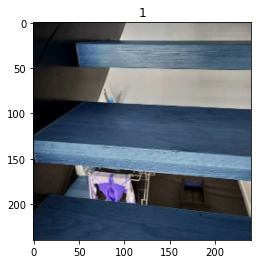

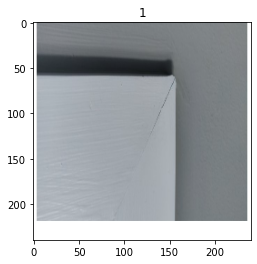

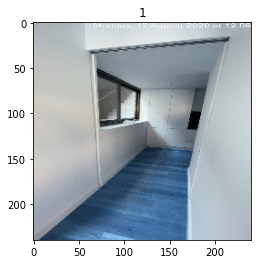

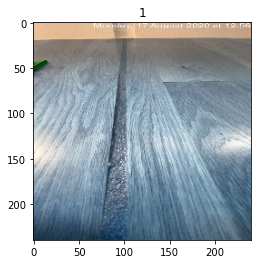

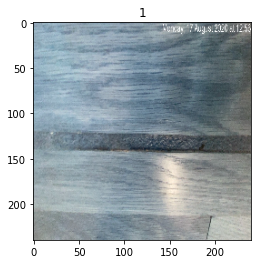

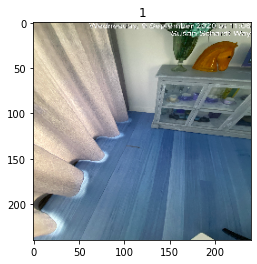

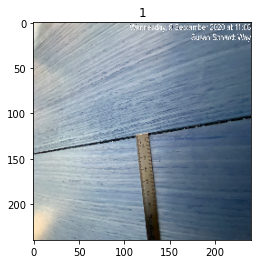

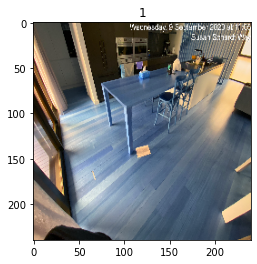

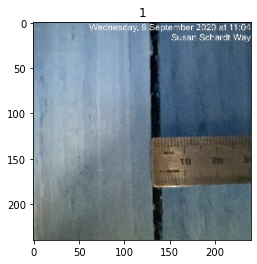

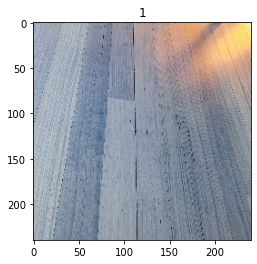

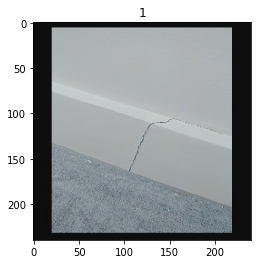

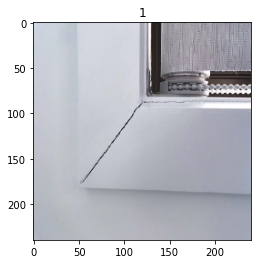

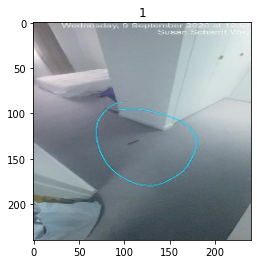

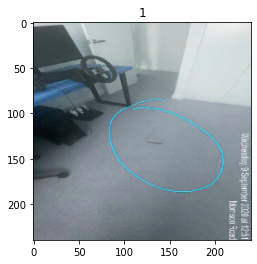

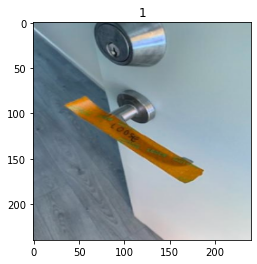

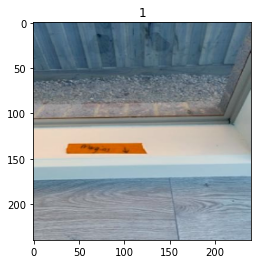

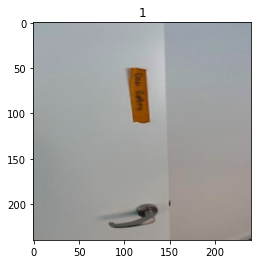

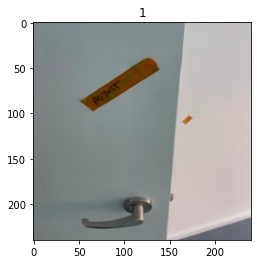

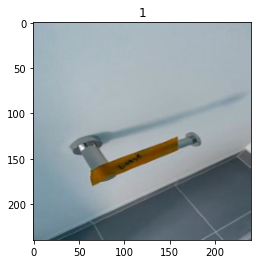

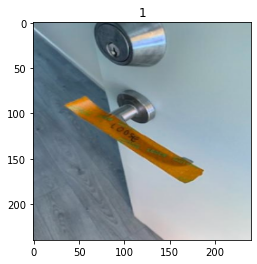

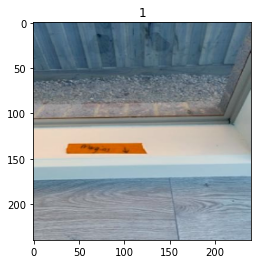

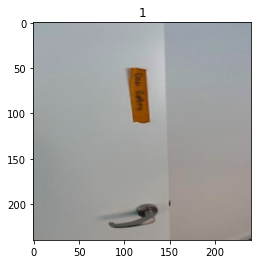

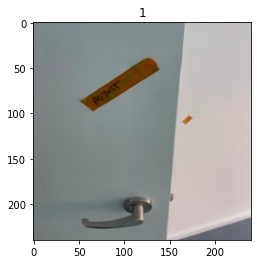

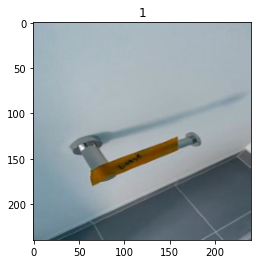

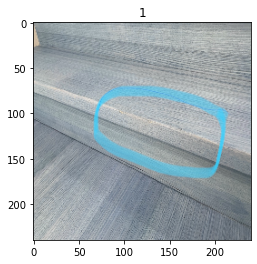

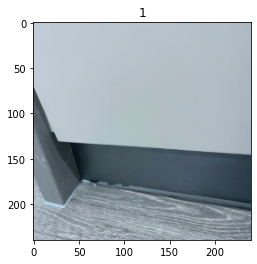

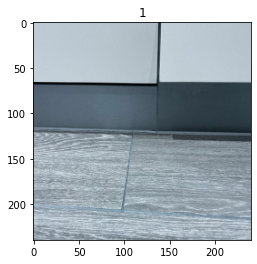

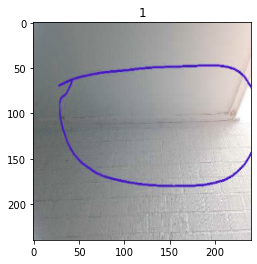

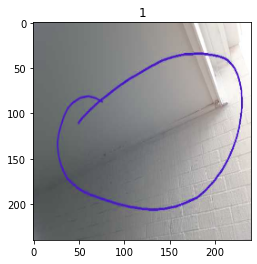

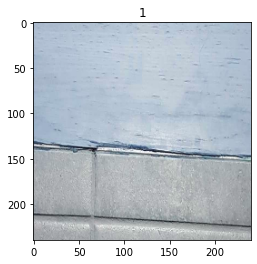

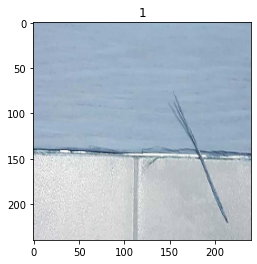

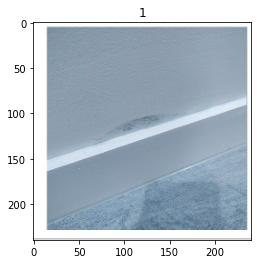

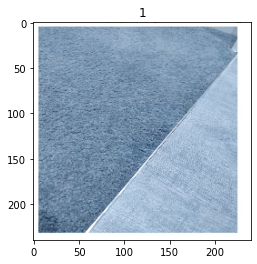

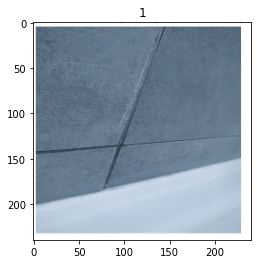

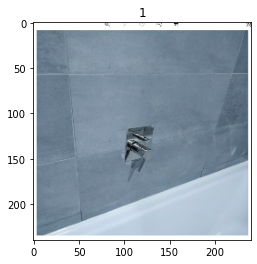

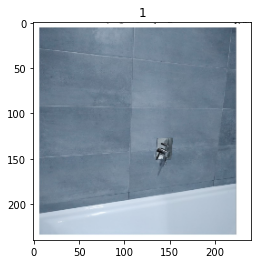

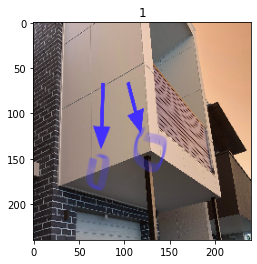

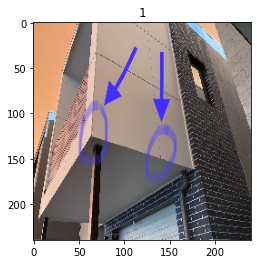

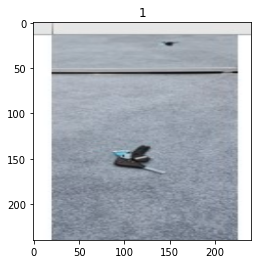

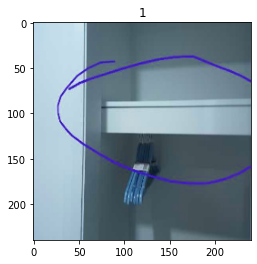

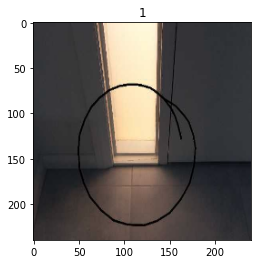

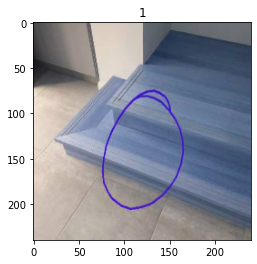

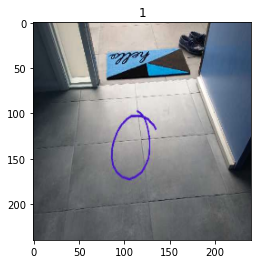

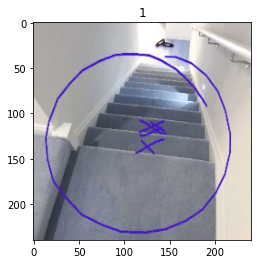

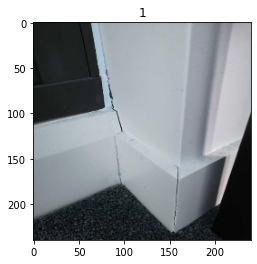

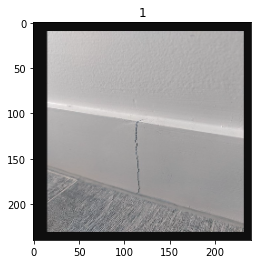

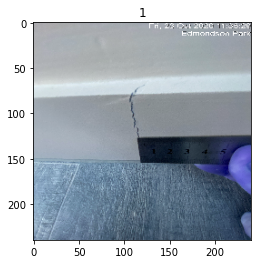

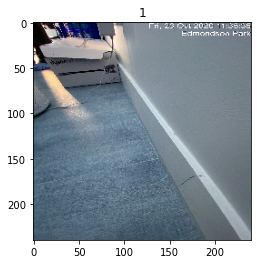

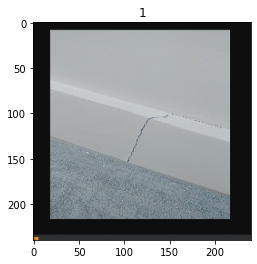

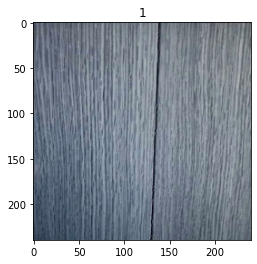

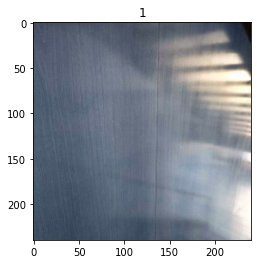

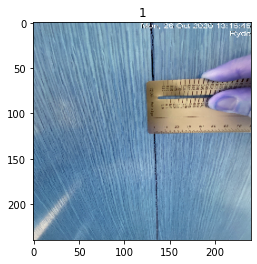

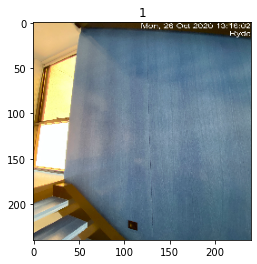

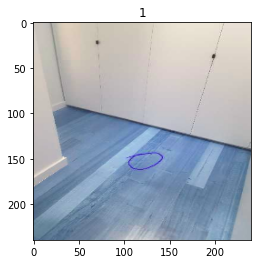

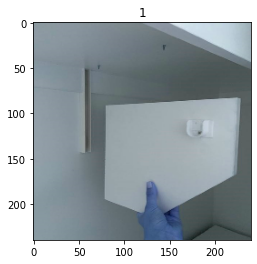

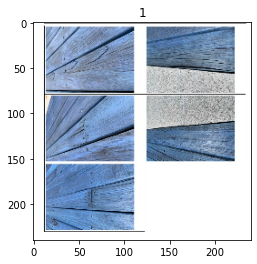

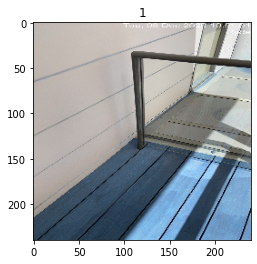

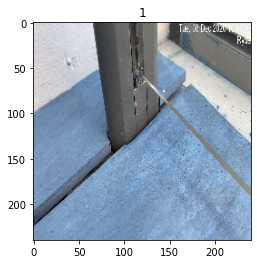

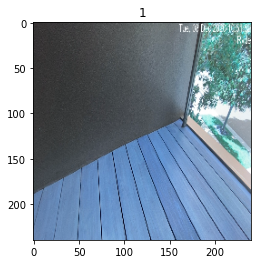

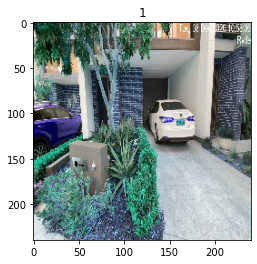

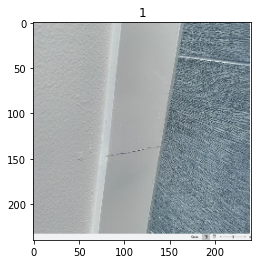

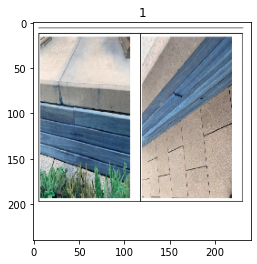

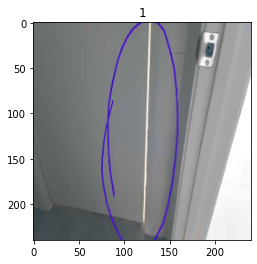

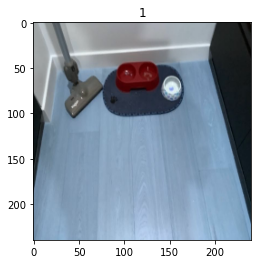

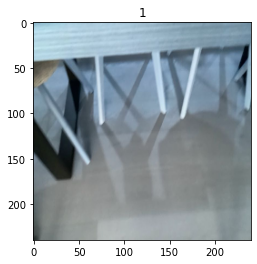

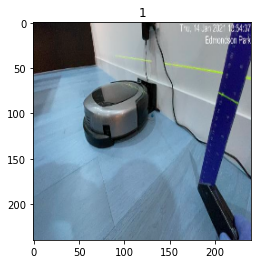

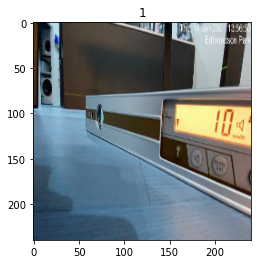

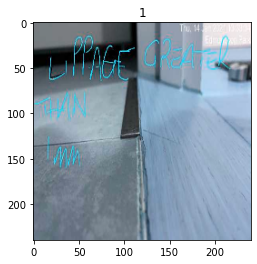

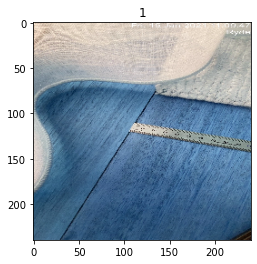

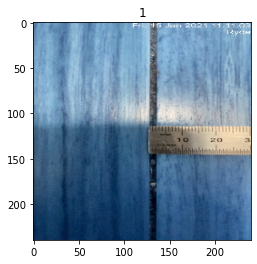

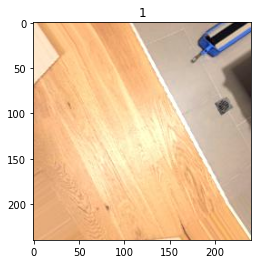

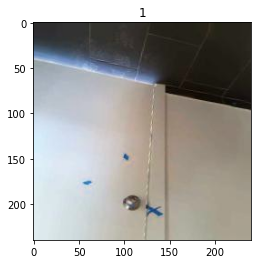

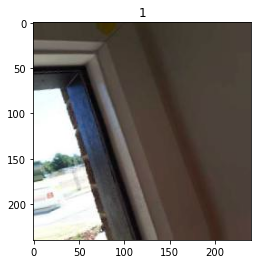

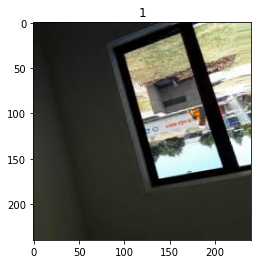

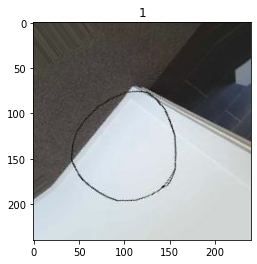

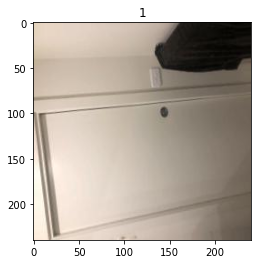

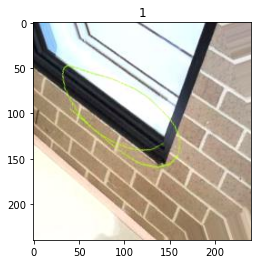

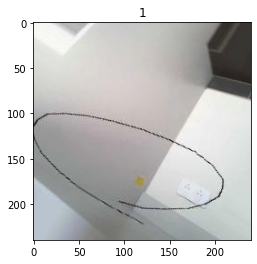

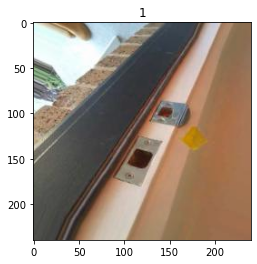

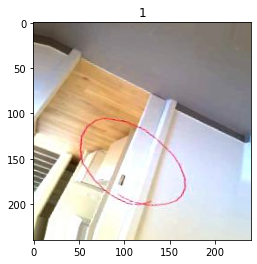

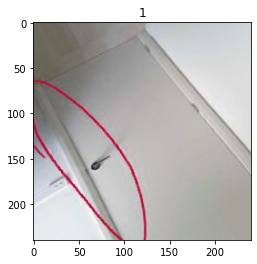

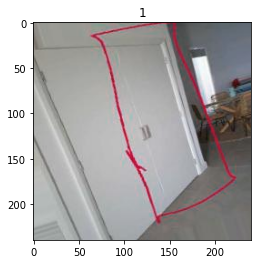

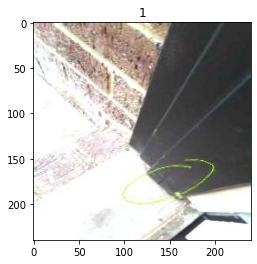

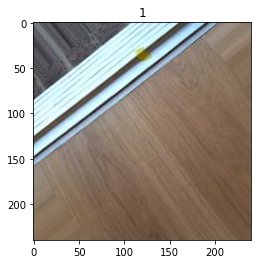

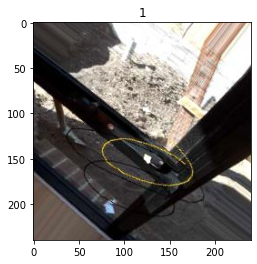

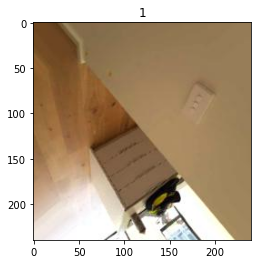

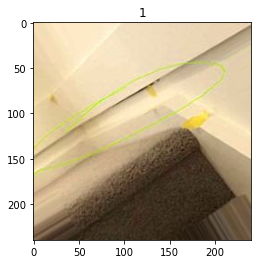

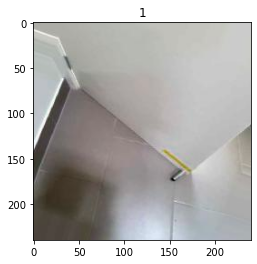

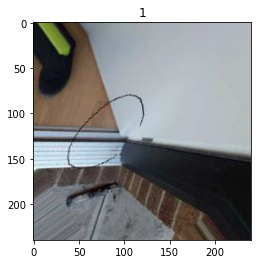

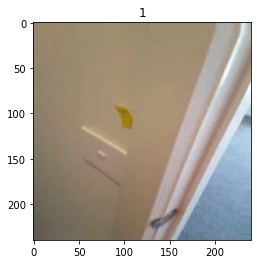

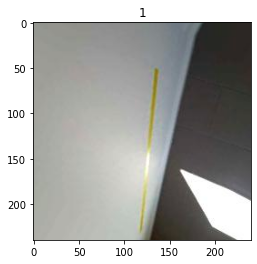

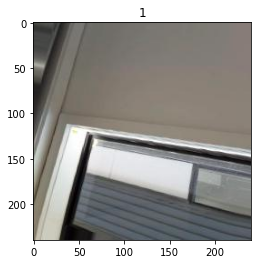

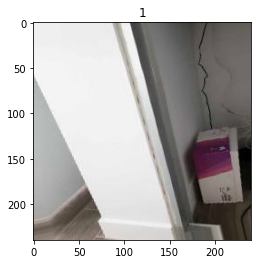

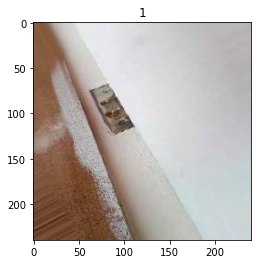

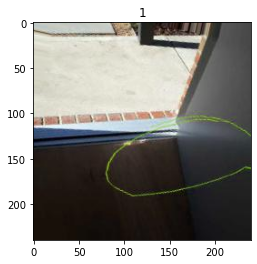

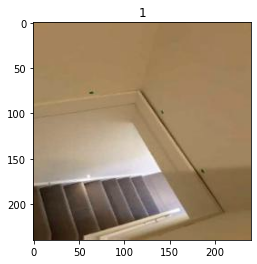

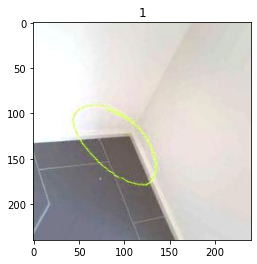

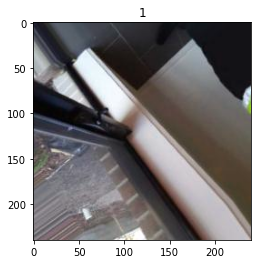

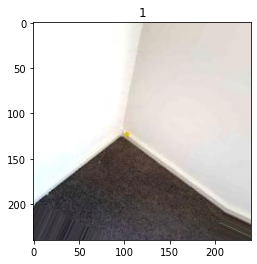

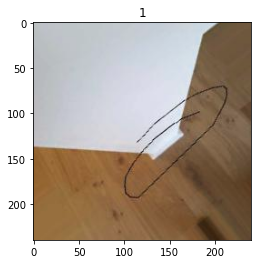

In [89]:
def test():
    for i in range(1000,1100):
        img = X[i]
        plt.title(y[i])
        plt.imshow(img)
        plt.show()
test()

In [91]:
def save_data_pickle():
    X_path = Path(r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\few-categories\X.pickle")
    y_path = Path(r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\few-categories\y.pickle")
    joblib.dump(X,X_path)
    joblib.dump(y,y_path)

['C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\few-categories\\X.pickle']

In [92]:
y_path = Path(r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\few-categories\y.pickle")

joblib.dump(y,y_path)

['C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\few-categories\\y.pickle']

In [160]:
path = "E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\Structural-Defect-Images-Categories\Other"
def test_external(path):
    other_list = []
    others = os.listdir(path)
    count = 0
    for img in others:
        img_path = os.path.join(path,img)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(240,240))
        img = img/255.
        print(img.shape)
        other_list.extend([img])
        if(count > 20):
            break
        count +=1
    return other_list
        
        

In [161]:
other_list = test_external(path)

(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)
(240, 240, 3)


In [162]:
other_list = np.array(other_list)

In [163]:
other_list[1].shape

(240, 240, 3)

In [168]:
save_path = r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\test_others_category"
joblib.dump(other_list,f"{save_path}\X.pickle")

['C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\test_others_category\\X.pickle']

In [167]:
save_path = r"C:\Users\sanketh\Desktop\JUPYTER\DEEP-LEARNING\test_others_category"

f"{save_path}\X.pickle"

'C:\\Users\\sanketh\\Desktop\\JUPYTER\\DEEP-LEARNING\\test_others_category\\X.pickle'

In [15]:
p = "E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\latest-images-backup\Appliances\8000073345_0000000010_1_MyProsperityDefectPhoto.jpe"

In [16]:
im = cv2.imread(p)

In [17]:
im.shape

(600, 800, 3)

In [18]:
im.resize(im,(260,260))

TypeError: only integer scalar arrays can be converted to a scalar index

In [122]:
i = [[1,2],[1,2,3]]

In [123]:
j =np.array(i)

<ipython-input-123-aeb325fa0129>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  j =np.array(i)


In [124]:
j.flatten()

array([list([1, 2]), list([1, 2, 3])], dtype=object)

In [179]:
pip install Augmentor


Note: you may need to restart the kernel to use updated packages.


In [198]:
import Augmentor

p = Augmentor.Pipeline(r"E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\Structural-Defect-Images-Categories\New folder")
p.rotate(probability=0.1, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.1, min_factor=1.1, max_factor=1.6)
p.sample(100)

Executing Pipeline:   0%|                                                                | 0/100 [00:00<?, ? Samples/s]

Initialised with 2 image(s) found.
Output directory set to E:\STRUCTURAL-DEFECT-DETECTION\STRUCTURAL-DEFECT-IMAGES\Structural-Defect-Images-Categories\New folder\output.

Processing <PIL.Image.Image image mode=RGBA size=545x471 at 0x27424C90760>:  23%|▏| 23/100 [00:03<00:12,  6.00 Samples/


KeyboardInterrupt: 

In [185]:
x = [[1,2],[1,2,3]]

In [186]:
np.asarray(x)

<ipython-input-186-b7822bdf15a8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(x)


array([list([1, 2]), list([1, 2, 3])], dtype=object)